<h1 style="color:rgb(0,120,170)">Assignment 8: CNNs </h1>

<h2 style="color:rgb(0,120,170)">Task 1: Explicit computation with CNNs</h2>




In this task you should do some computuations for CNNs explicitly to gain further understanding how the corresponding operations work. Asume you are given the following input image, represented as $\mathbf{x}=\begin{pmatrix} 1 & 0 & 1 & 1 & 0 \\ 0 & 1 & 1 & 0 & 1 \\ 0 & 1 & 0 & 1 & 1 \\ 1 & 1 & 0 & 1 & 1 \\ 0 & 1 & 1 & 1 & 0 \end{pmatrix}$.
* Consider the filter $\mathbf{W}=\begin{pmatrix} 1 & 1 & 1 \\ 0 & 2 & 0 \\ 1 & 1 & 1 \end{pmatrix}$ and compute $\mathbf{s}=\mathbf{W} * \mathbf{x}$. Use the formula from the lecture to write down the individual summands of $s_{1,1}$ explicitly. The other components of $\mathbf{s}$ may be calculated by a python routine or by hand.
* Repeat the calculation $\mathbf{s}$, but this time apply a stride of $S=2$.
* Let's say we want to have feature maps $6 \times 6$. What is the amount of zero padding we need if we use the stride $S=2$?

<h3 style="color:rgb(208,90,80)">Calculation (30 points)</h3>


\begin{align*}
s_{1,1} &= w_{0,0}x_{1,1}+w_{1,1}x_{2,2}+w_{2,2}x_{3,3}+w_{0,1}x_{1,2}+w_{0,2}x_{1,3}+w_{1,0}x_{2,1}
+w_{1,2}x_{2,3}+w_{2,0}x_{3,1}+w_{2,1}x_{3,2}\\
&= 1*1 + 2*1 + 1*0 + 1*0 + 1*1 + 0*0 + 0*1 + 1*0 + 1*1\\
&= 5
\end{align*}

In [1]:
import numpy as np
x = np.asarray([[1,0,1,1,0],[0,1,1,0,1],[0,1,0,1,1],[1,1,0,1,1],[0,1,1,1,0]])
W = np.asarray([[1,1,1],[0,2,0],[1,1,1]])

In [2]:
import numpy as np
s = np.zeros((3,3))
for a in range(1,4):

    for b in range(1,4):
        s_ab = 0 
        
        for w_coordinates1 in range(0,3):
            
            for w_coordinates2 in range(0,3):
                s_ab += W[w_coordinates1][w_coordinates2] * x[a+w_coordinates1-1][b+w_coordinates2-1]

        s[a-1][b-1] = s_ab
print(s)

[[5. 6. 4.]
 [6. 4. 6.]
 [5. 5. 6.]]


In [3]:
import numpy as np
s = np.zeros((2,2))
for a in [1,3]:
    for b in [1,3]:
        s_ab = 0  
        
        for w_coordinates1 in range(0,3):
            
            for w_coordinates2 in range(0,3):
                s_ab += W[w_coordinates1][w_coordinates2] * x[a+w_coordinates1-1][b+w_coordinates2-1]

        if a == 1 and b==1:
            s[a-1][b-1] = s_ab
        elif a==1 and b==3: 
            s[a-1][b-2] = s_ab
        elif a==3 and b==1:
            s[a-2][b-1] = s_ab
        else:
            s[a-2][b-2] = s_ab
print(s)

[[5. 4.]
 [5. 6.]]


Answer third point:
\begin{align*}
A &= H-R+1\\
6 &= H - 4\\
H &= 10
\end{align*}
x shall have size of 10x10. Originally 5x5. --> We need 4 extra rows and columns of each side of the matrix. --> padding p=4

<h2 style="color:rgb(0,120,170)">Task 2: CNNs vs. the rest</h2>

In this task we will carry out a comparison of several classifiers on different portions of the Fashio MNIST data set. From the whole training data we create smaller training sets that have $[0.05,0.1,0.25, 0.5, 1.0]$ times the the size of the total set. Compared to the previous assignment, the data loader is modified a little so that it outputs different formats for the computations with Pytorch, where we use tensors, and sklearn, where we use numpy arrays.

<h3 style="color:rgb(208,90,80)">Google colab</h3>

In case you want to keep the run times low you might want to use Google colab for this task. This will provide you with free access to GPUs. 

Running jupyter notebooks on colab is very simple:
click the [Link to this notebook on Colab](https://colab.research.google.com/drive/1yS6o6MJFud2ZP7UTlJsLF_lCzMwhQm-B?usp=sharing) and follow the instructions of the "How to run on Colab" pdf. 

However, colab requires a google account. If you cannot use Google colab you can of course also run this notebook on your local machine, the run times should be reasonable (depending on your hardware).

In [4]:
CALCULATE_ALL = False ## if True recalculate all entries in experiments, otherwise just the result for 5% and 10% data

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from IPython.display import clear_output, display
from torch._six import int_classes as _int_classes

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [7]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
# used to train the CNN

### use Pytorch dataloader with a subset of the training data
def get_sampler(N_samples):  
    mask = list(np.arange(N_samples))  ## list of valid sample_ids
    return torch.utils.data.RandomSampler(mask) ## random order


def get_data_loader(use_cuda,batch_size=64,train=True,get_all=False,sampler=None):
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(os.path.join('.','..','data')
                            ,train=train, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])), shuffle=False, sampler=sampler, batch_size=batch_size,**kwargs)
    ## return numpy arrays of the dataset
    if get_all: 
        for _, (train_samples, train_labels) in enumerate(loader):
            return train_samples.numpy().reshape(-1,28*28),train_labels.numpy()
    ## return loader to provide minibatches
    else:
        return loader

### prepare data for sklearn models
train_samples, train_labels = get_data_loader(use_cuda,batch_size=6*10**4,train=True,get_all = True)
test_samples, test_labels = get_data_loader(use_cuda,batch_size=10**4,train=False,get_all = True)

Now we want to apply different models to our prepared data. We also want to print and store accuracy, training time and inference time, so these should be our results. In the dictionary "experminents" we want to store these informations in an array for the different models and different training data sizes. Just let the code run to understand better what is meant exactly.

In [8]:
models = ["RF_100","RF_500","SVM","CNN_simple","CNN_wide","CNN_deep","CNN_wide_max"]
results = ["accuracy","training_time","inference_time"]
experiments = {}
experiments["percentages"] = np.array([0.05,0.1,0.25,0.5,1.0])
experiments["N_samples"] = (60000 * experiments["percentages"]).astype(np.int)

for k in models:
    experiments[k] = {}
    for l in results:
        experiments[k][l] = np.zeros([len(experiments["N_samples"])])
        
## to save time, you can use precomputed values for the larger subsets
if not CALCULATE_ALL:
    experiments["N_samples"] = experiments["N_samples"][:-3]
    experiments["RF_100"]["accuracy"][-3:],experiments["RF_100"]["training_time"][-3:],experiments["RF_100"]["inference_time"][-3:]  = \
        np.array([85.67, 86.76, 87.77]), np.array([13.22, 29.77, 67.63]), np.array([0.32, 0.35, 0.4])
    experiments["RF_500"]["accuracy"][-3:],experiments["RF_500"]["training_time"][-3:],experiments["RF_500"]["inference_time"][-3:]  = \
        np.array([85.97, 86.97, 87.86]), np.array([65.26, 148.64, 337.84]), np.array([1.53, 1.72, 1.95])
    experiments["SVM"]["accuracy"][-3:],experiments["SVM"]["training_time"][-3:],experiments["SVM"]["inference_time"][-3:]  = \
        np.array([ 86.14, 87.03, 88.28]), np.array([40.43, 130.63, 433.99]), np.array([49.58,  88.61, 157.68])
    experiments["RF_100"]["accuracy"][-3:],experiments["RF_100"]["training_time"][-3:],experiments["RF_100"]["inference_time"][-3:]  = \
    np.array([85.67, 86.76, 87.77]), np.array([13.22, 29.77, 67.63]), np.array([0.32, 0.35, 0.4])
    experiments["CNN_simple"]["accuracy"][-3:],experiments["CNN_simple"]["training_time"][-3:],experiments["CNN_simple"]["inference_time"][-3:]  = \
        np.array([ 83.28, 85.66, 87.9]), np.array([40.76,  80.33, 162.19]), np.array([1.29, 1.35, 1.32])
    experiments["CNN_wide"]["accuracy"][-3:],experiments["CNN_wide"]["training_time"][-3:],experiments["CNN_wide"]["inference_time"][-3:]  = \
        np.array([84.83, 86.7 , 90.48]), np.array([40.6 ,  81.93, 160.84]), np.array([1.32, 1.33, 1.35])
    experiments["CNN_deep"]["accuracy"][-3:],experiments["CNN_deep"]["training_time"][-3:],experiments["CNN_deep"]["inference_time"][-3:]  = \
        np.array([ 88.95, 90.08, 91.86]), np.array([42.48,  82.38, 162.91]), np.array([1.34, 1.31, 1.32])
    experiments["CNN_wide_max"]["accuracy"][-3:],experiments["CNN_wide_max"]["training_time"][-3:],experiments["CNN_wide_max"]["inference_time"][-3:]  = \
        np.array([89.57, 90.12, 91.02]), np.array([41.09,  82.07, 161.16]), np.array([1.3 , 1.36, 1.33])
    
experiments

{'percentages': array([0.05, 0.1 , 0.25, 0.5 , 1.  ]),
 'N_samples': array([3000, 6000]),
 'RF_100': {'accuracy': array([ 0.  ,  0.  , 85.67, 86.76, 87.77]),
  'training_time': array([ 0.  ,  0.  , 13.22, 29.77, 67.63]),
  'inference_time': array([0.  , 0.  , 0.32, 0.35, 0.4 ])},
 'RF_500': {'accuracy': array([ 0.  ,  0.  , 85.97, 86.97, 87.86]),
  'training_time': array([  0.  ,   0.  ,  65.26, 148.64, 337.84]),
  'inference_time': array([0.  , 0.  , 1.53, 1.72, 1.95])},
 'SVM': {'accuracy': array([ 0.  ,  0.  , 86.14, 87.03, 88.28]),
  'training_time': array([  0.  ,   0.  ,  40.43, 130.63, 433.99]),
  'inference_time': array([  0.  ,   0.  ,  49.58,  88.61, 157.68])},
 'CNN_simple': {'accuracy': array([ 0.  ,  0.  , 83.28, 85.66, 87.9 ]),
  'training_time': array([  0.  ,   0.  ,  40.76,  80.33, 162.19]),
  'inference_time': array([0.  , 0.  , 1.29, 1.35, 1.32])},
 'CNN_wide': {'accuracy': array([ 0.  ,  0.  , 84.83, 86.7 , 90.48]),
  'training_time': array([  0.  ,   0.  ,  40.6 , 

Next we want to apply this routine to the sklearn models first (i.e RFs and SVMs) for the different sizes of the data set. We implemented the routine for Random Forest with 100 estimators:

In [9]:
### experiments['RF_100'] ...
for i,n_samples in enumerate(experiments["N_samples"]):
    print("Subset consists of {} samples".format(n_samples))
    model = RandomForestClassifier(n_estimators=100)
    
    start_train= time.time()
    model.fit(train_samples[:n_samples],train_labels[:n_samples])
    end_train = time.time()
    train_time = np.round(end_train-start_train,decimals=2)
    experiments["RF_100"]["training_time"][i] = train_time 
    print("training took {:.2f} seconds".format(train_time))
    
    start_infer= time.time()
    pred = model.predict(test_samples)
    end_infer = time.time()
    infer_time = np.round(end_infer-start_infer,decimals=2)
    experiments["RF_100"]["inference_time"][i] = infer_time
    print("inference took {:.2f} seconds".format(infer_time))
    
    accuracy = np.round(sum((pred-test_labels)==0)/len(test_labels)*100,
                        decimals=2)
    print("test accuracy: {:.2f} percent".format(accuracy))
    experiments["RF_100"]["accuracy"][i] = accuracy

Subset consists of 3000 samples
training took 2.34 seconds
inference took 0.22 seconds
test accuracy: 82.42 percent
Subset consists of 6000 samples
training took 4.88 seconds
inference took 0.26 seconds
test accuracy: 83.86 percent


* Implement a similar routine for RFs with 500 estimators and SVMs with default parameters, so that the ouput values are stored in the right place in the dictionary "experiments".

<h3 style="color:rgb(208,90,80)">Code (20 points)</h3>

In [10]:
### Your code for experiments['RF_500'] ...
for i,n_samples in enumerate(experiments["N_samples"]):
    print("Subset consists of {} samples".format(n_samples))
    model = RandomForestClassifier(n_estimators=500)
    
    start_train= time.time()
    model.fit(train_samples[:n_samples],train_labels[:n_samples])
    end_train = time.time()
    train_time = np.round(end_train-start_train,decimals=2)
    experiments["RF_500"]["training_time"][i] = train_time 
    print("training took {:.2f} seconds".format(train_time))
    
    start_infer= time.time()
    pred = model.predict(test_samples)
    end_infer = time.time()
    infer_time = np.round(end_infer-start_infer,decimals=2)
    experiments["RF_500"]["inference_time"][i] = infer_time
    print("inference took {:.2f} seconds".format(infer_time))
    
    accuracy = np.round(sum((pred-test_labels)==0)/len(test_labels)*100,
                        decimals=2)
    print("test accuracy: {:.2f} percent".format(accuracy))
    experiments["RF_500"]["accuracy"][i] = accuracy
    

Subset consists of 3000 samples
training took 20.97 seconds
inference took 1.49 seconds
test accuracy: 83.00 percent
Subset consists of 6000 samples
training took 41.54 seconds
inference took 2.41 seconds
test accuracy: 84.27 percent


In [11]:
### Your code for experiments['SVM'] ...
for i,n_samples in enumerate(experiments["N_samples"]):
    print("Subset consists of {} samples".format(n_samples))
    model = SVC() # use default values = standard values
    
    start_train= time.time()
    model.fit(train_samples[:n_samples],train_labels[:n_samples])
    end_train = time.time()
    train_time = np.round(end_train-start_train,decimals=2)
    experiments["SVM"]["training_time"][i] = train_time 
    print("training took {:.2f} seconds".format(train_time))
    
    start_infer= time.time()
    pred = model.predict(test_samples)
    end_infer = time.time()
    infer_time = np.round(end_infer-start_infer,decimals=2)
    experiments["SVM"]["inference_time"][i] = infer_time
    print("inference took {:.2f} seconds".format(infer_time))
    
    accuracy = np.round(sum((pred-test_labels)==0)/len(test_labels)*100,
                        decimals=2)
    print("test accuracy: {:.2f} percent".format(accuracy))
    experiments["SVM"]["accuracy"][i] = accuracy
    

Subset consists of 3000 samples
training took 3.34 seconds
inference took 28.42 seconds
test accuracy: 82.32 percent
Subset consists of 6000 samples
training took 15.77 seconds
inference took 48.34 seconds
test accuracy: 84.13 percent


Now we want to run similar experiments with four different CNN models.
We first provide the training and test routine for the CNNs. You just have to input the model, the device, the dataloaders (which might be adapted to the sizes of the datasets), the optimizer and the number of epochs.

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train() 
    correct=0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.shape[0]
    print('Epoch {} \nTraining Accuracy: {}/{} ({:.2f}%)'.format(epoch,
    correct, total, 100*correct/total 
    )) 
    
def test(model, device, test_loader):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = np.round(100. * correct / len(test_loader.dataset),decimals=2)
    print('Test Accuracy: {}/{} ({:.2f}%)'.format(correct, len(test_loader.dataset), accuracy)) 
    return accuracy

Here we provide a routine that creates CNN models. It takes as inputs the hyper-parameters of the CNNs. It's not necessary to fully understand this routine at this stage, as this will be a main topic in further courses (e.g. Deep Learning 1&2).

In [13]:
class Net(nn.Module):
    def __init__(self,use_batch_norm=True,n_blocks=3,n_layers=3,channels = 32, multiply_channels=2, global_max = True):
        super(Net, self).__init__(),
        self.use_batch_norm = use_batch_norm
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.channels = channels
        self.multiply_channels = multiply_channels
        self.global_max = global_max

        ## feature extraction CNN => linear layer (N_cannels to N_classes) => softmax
        self.cnn_module = self.build_model() 
        self.fc_module = nn.Sequential(
            nn.Linear(channels*multiply_channels**(n_blocks-1), 10)) 
        
    def build_model(self):
        channels_per_layer = [1,self.channels]
        for i in range(1,self.n_blocks):
            channels_per_layer.append(self.channels*self.multiply_channels**i)   
        
        components = []
        for i in range(self.n_blocks):
            for j in range(self.n_layers):
                if j== 0:
                    cur_dims = [channels_per_layer[i],channels_per_layer[i+1]]   ## first layer of the block
                else: 
                    cur_dims = [channels_per_layer[i+1],channels_per_layer[i+1]]

                if self.use_batch_norm:        ## no bias needed
                    components.append(
                        nn.Sequential(nn.Conv2d(cur_dims[0], cur_dims[1], kernel_size = 3,padding=1,bias=False),
                                     nn.BatchNorm2d(cur_dims[1], momentum=0.1),
                                     nn.ReLU()
                                     )
                    )
                else:                          
                    components.append(
                        nn.Sequential(nn.Conv2d(cur_dims[0], cur_dims[1], kernel_size = 3,padding=1),
                                     nn.ReLU()
                                     )
                    )
            if i == self.n_blocks-1:
                if self.global_max:
                    components.append(nn.Sequential(nn.AdaptiveMaxPool2d(1)))    ## finish with a global max pooling layer
                else:
                    components.append(nn.Sequential(nn.AdaptiveAvgPool2d(1)))    ## finish with a global average pooling layer
            else: 
                components.append(nn.Sequential(nn.MaxPool2d(2, stride = 2)))  ## downsampling via max_pooling of stride 2
        return nn.Sequential(*components)
        
    def forward(self, x):   
        x = self.cnn_module(x)    
        x = x.view(x.size(0), -1) 
        x = self.fc_module(x)     
        return F.log_softmax(x, dim=1)

Now let us run the different CNN models for the different sizes of the data sets.
You should run the experiments with the following four CNN models:
- a simple CNN with average pooling,, called "CNN_simple"
- a wide CNN with average pooling,, called "CNN_wide"
- a deep CNN with average pooling, called "CNN_deep"
- a wide CNN with max pooling, called "CNN_wide_max"

This is done now in a similar fashion as for the sklearn methods. Again accuracy, training time and test time are stored in the experiments dictionary for the different sizes of the data sets. The number of trainable parameters for each of the four different CNNs is printed in the begining of the training loop of the corresponding model. This should allow you to get a rough idea of the complexities of these models.

<h3 style="color:rgb(208,90,80)"> Conduct experiments (20 points)</h3>

In [14]:
max_epochs = 5

for model_tag in ["CNN_simple","CNN_wide","CNN_deep","CNN_wide_max"]:
    for i,n_samples in enumerate(experiments["N_samples"]):
        if  model_tag == "CNN_simple":
            ## a simple 'CNN with 3 layers with 16 channels each
            model = Net(use_batch_norm=True,n_blocks=3,n_layers=1,channels = 16, multiply_channels=1,global_max=False).to(device)  ## simple
        elif model_tag == "CNN_wide":
            ## a wider version with 3 layers with 16,32 and 64 channels
            model = Net(use_batch_norm=True,n_blocks=3,n_layers=1,channels = 32, multiply_channels=2,global_max=False).to(device)  ## wide
        elif model_tag == "CNN_deep":
            ## a deeper version with 9 layers with 16 channels each
            model = Net(use_batch_norm=True,n_blocks=3,n_layers=3,channels = 16, multiply_channels=1,global_max=False).to(device)  ## deep
        elif model_tag == "CNN_wide_max":
            ## a wider version with 3 layers with 16, 32 and 64 channels, global maximum pooling
            model = Net(use_batch_norm=True,n_blocks=3,n_layers=1,channels = 32, multiply_channels=2,global_max=True).to(device)  ## wide       

        optimizer = optim.Adam(model.parameters())
        sampler = get_sampler(experiments["N_samples"][i])
        train_loader = get_data_loader(use_cuda,64,train=True,sampler=sampler)
        test_loader = get_data_loader(use_cuda,128,train=False)

        if i == 0:
            print(model)
            print("\nThe model has {} parameters\n".format(sum(p.numel() for p in model.parameters())))
            
        print("Subset consists of {} samples".format(n_samples))
        epoch_times = []
        infer_times = []
        accuracies = []
        for epoch in range(1,max_epochs+1):
            start_epoch=time.time()
            train(model, device, train_loader, optimizer, epoch)
            end_epoch=time.time()
            epoch_time = np.round(end_epoch-start_epoch,decimals=2)
            epoch_times.append(epoch_time)
            
            print("epoch took {:.2f} seconds".format(epoch_time))
            start_infer = time.time()
            accuracies.append(test(model, device, test_loader))
            end_infer=time.time()
            infer_time = np.round(end_infer-start_infer,decimals=2)
            infer_times.append(infer_time)
            print("inference took {:.2f} seconds".format(infer_time))
        
        print("finished " + model_tag + " with {}".format(n_samples))
        experiments[model_tag]["accuracy"][i] = np.round(np.mean(np.array(accuracies[-3:])),decimals=2)  #average over final 3 epochs
        experiments[model_tag]["training_time"][i] = np.round(np.sum(np.array(epoch_times)),decimals=2)  # sum over all epochs
        experiments[model_tag]["inference_time"][i] = np.round(np.mean(np.array(infer_times)),decimals=2)  #mean inference time
        for k in experiments[model_tag].keys():
            print(k, experiments[model_tag][k])
        print()

experiments

Net(
  (cnn_module): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): Sequential(
      (0): AdaptiveAvgPool2d(output_size=1)
  

Epoch 1 
Training Accuracy: 1044/3000 (34.80%)
epoch took 0.75 seconds
Test Accuracy: 4615/10000 (46.15%)
inference took 2.17 seconds
Epoch 2 
Training Accuracy: 1704/3000 (56.80%)
epoch took 0.89 seconds
Test Accuracy: 6221/10000 (62.21%)
inference took 3.43 seconds
Epoch 3 
Training Accuracy: 1955/3000 (65.17%)
epoch took 1.26 seconds
Test Accuracy: 6629/10000 (66.29%)
inference took 2.91 seconds
Epoch 4 
Training Accuracy: 2092/3000 (69.73%)
epoch took 1.02 seconds
Test Accuracy: 6892/10000 (68.92%)
inference took 2.67 seconds
Epoch 5 
Training Accuracy: 2172/3000 (72.40%)
epoch took 0.92 seconds
Test Accuracy: 6609/10000 (66.09%)
inference took 2.50 seconds
finished CNN_deep with 3000
accuracy [67.1   0.   88.95 90.08 91.86]
training_time [  4.84   0.    42.48  82.38 162.91]
inference_time [2.74 0.   1.34 1.31 1.32]

Subset consists of 6000 samples
Epoch 1 
Training Accuracy: 2917/6000 (48.62%)
epoch took 1.44 seconds
Test Accuracy: 6622/10000 (66.22%)
inference took 2.17 seconds
E

{'percentages': array([0.05, 0.1 , 0.25, 0.5 , 1.  ]),
 'N_samples': array([3000, 6000]),
 'RF_100': {'accuracy': array([82.42, 83.86, 85.67, 86.76, 87.77]),
  'training_time': array([ 2.34,  4.88, 13.22, 29.77, 67.63]),
  'inference_time': array([0.22, 0.26, 0.32, 0.35, 0.4 ])},
 'RF_500': {'accuracy': array([83.  , 84.27, 85.97, 86.97, 87.86]),
  'training_time': array([ 20.97,  41.54,  65.26, 148.64, 337.84]),
  'inference_time': array([1.49, 2.41, 1.53, 1.72, 1.95])},
 'SVM': {'accuracy': array([82.32, 84.13, 86.14, 87.03, 88.28]),
  'training_time': array([  3.34,  15.77,  40.43, 130.63, 433.99]),
  'inference_time': array([ 28.42,  48.34,  49.58,  88.61, 157.68])},
 'CNN_simple': {'accuracy': array([60.96, 70.07, 83.28, 85.66, 87.9 ]),
  'training_time': array([  3.59,   7.08,  40.76,  80.33, 162.19]),
  'inference_time': array([1.96, 2.11, 1.29, 1.35, 1.32])},
 'CNN_wide': {'accuracy': array([70.71, 79.2 , 84.83, 86.7 , 90.48]),
  'training_time': array([  4.08,   8.91,  40.6 , 

As a final task make the following three plots:
- accuracies against size of the dataset
- inference times against size of the dataset
- training times against size of the dataset

Compare all six models in each of these three plots and don't forget to label the plots appropriately!

<h3 style="color:rgb(208,90,80)"> Code (20 points)</h3>

In [15]:
#clear_output(wait=False)
rf100 = experiments['RF_100']
rf500 = experiments['RF_500']
svm = experiments['SVM']
cnnsimple = experiments['CNN_simple']
cnnwide = experiments['CNN_wide']
cnndeep = experiments['CNN_deep']
cnnmax = experiments['CNN_wide_max']

ts = len(train_samples)
list_of_sample_size = [3000,6000,int(ts*0.25),int(ts*0.5),ts]


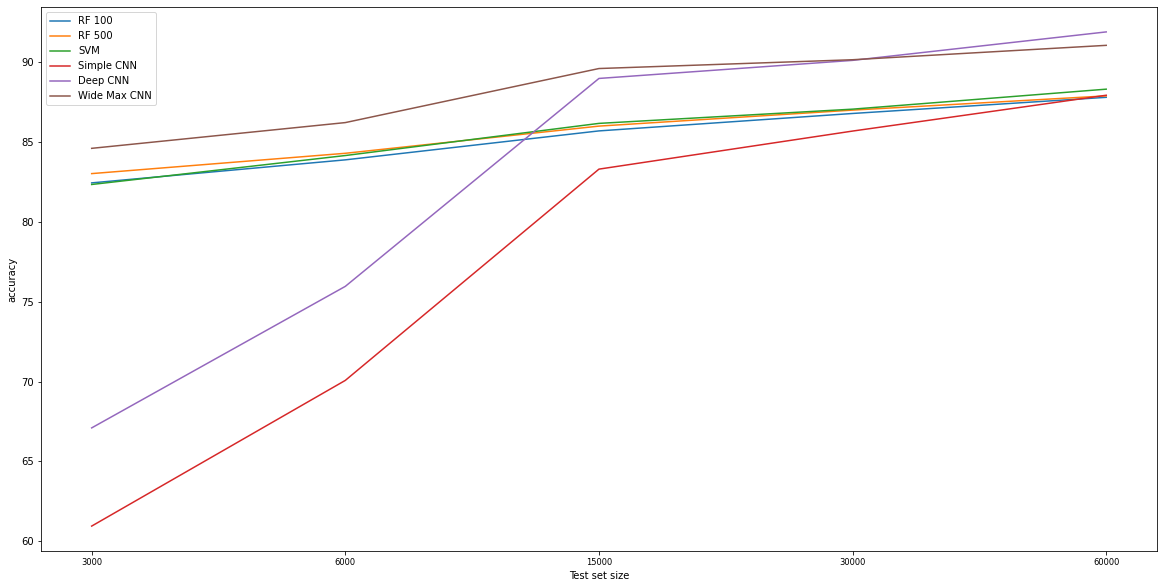

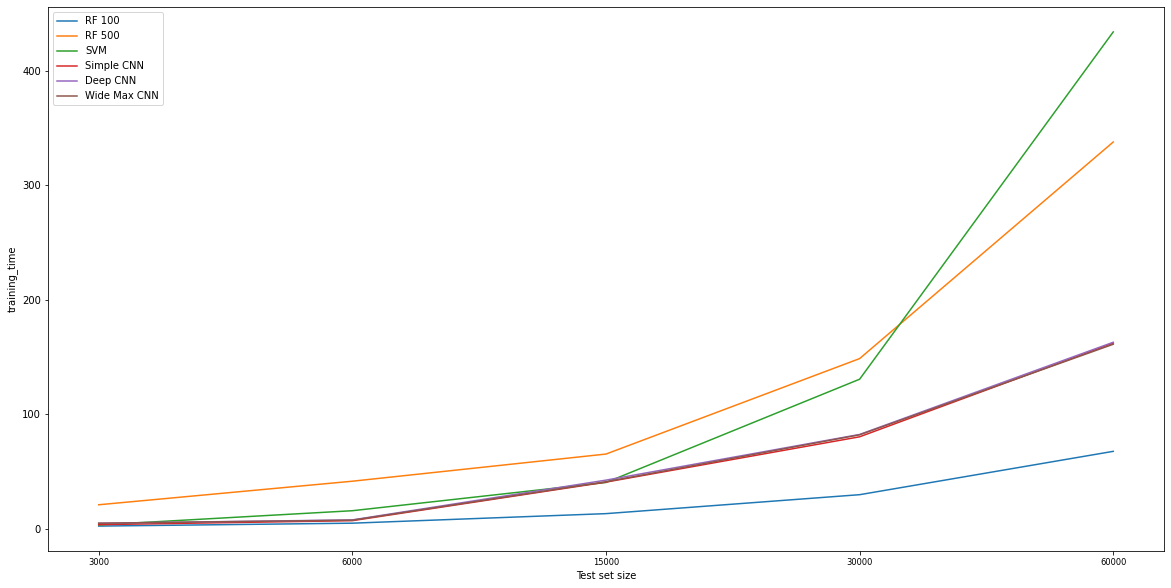

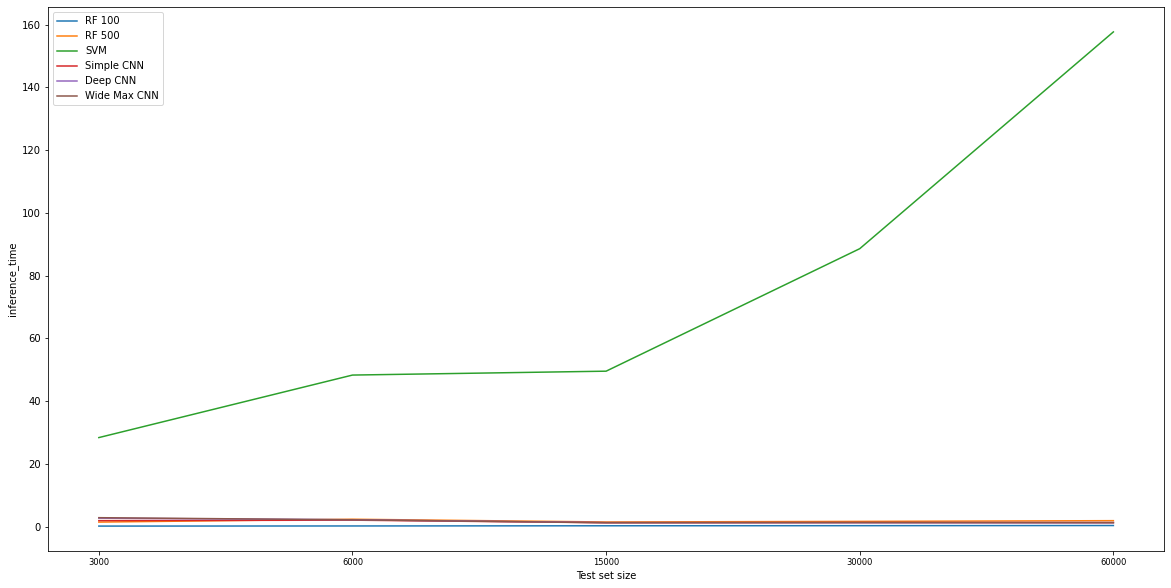

In [17]:
import matplotlib.pyplot as plt

for i in ['accuracy', 'training_time', 'inference_time']:
    rf100_a = rf100[i]
    rf500_a = rf500[i]
    svm_a = svm[i]
    cnnsimple_a = cnnsimple[i]
    cnnwide_a = cnnwide[i]
    cnndeep_a = cnndeep[i]
    cnnmax_a = cnnmax[i]

    fig=plt.figure(figsize=(20,10)) #Creates a new figure
    
    ax1=fig.add_subplot(111) 
    
    ax1.plot(rf100_a,label='RF 100') 
    ax1.plot(rf500_a,label='RF 500') 

    ax1.plot(svm_a,label='SVM') 
    
    ax1.plot(cnnsimple_a,label='Simple CNN') 
    ax1.plot(cnndeep_a,label='Deep CNN') 
    ax1.plot(cnnmax_a,label='Wide Max CNN') 


    plt.setp(ax1.get_xticklabels(), visible=True) #not ax2
    plt.xticks(range(len(list_of_sample_size)), list_of_sample_size, size='small')
    plt.legend()
    plt.xlabel('Test set size')
    plt.ylabel(i)
   

<h3 style="color:rgb(208,90,80)">Question (10 points)</h3>

Tick the boxes with correct statements:

\[X\] Inference and training times indicate that SVMs are not feasible on large data sets.<br>
\[X\] A comparison of different algorithms is fair as long as they are compared on the same problem, i.e. the same training and test data.<br>
\[ \] A comparison of different algorithms should take into account the number of trainable model parameters or the training and inference times.<br>
\[ \] Monitoring the performance on the training data is pointless during training since only the performance on the test data counts.<br>
\[X\] On small data sets the SVM and Random Forests achieve higher accuracy than the simple CNN.<br>
\[X\] Monitoring the performance on the training data and the test data is necessary to spot over-training.<br>

The take home messages of this task are:
- the model choice depends on the size and complexity of the data set
- the model choice is constrained by the available computing and time resources
- neural networks are often a good choice for large data sets, e.g. CNNs on computer vision tasks
- for smaller problems alternatives like SVM or Random Forests can be more efficient
- there is no algorithm that guarantees superior performance on every problem (aka "No free lunch theorem")

<h3 style="color:rgb(208,90,80)"> Bonus Question (5 possible extra points) </h3>

* The CNN architectures we presented here are far from being optimally designed. As a final challenge you can try to create a CNN, that does even better on Fashion MNIST than the ones we presented here (using the same or different building blocks, it is completely up to you!)

In [38]:
acc = []
traintime =[]
inftime =[]

for i,n_samples in enumerate(experiments["N_samples"]):
    model = Net(use_batch_norm=True,n_blocks=3,n_layers=2,channels = 38, multiply_channels=2,global_max=True).to(device) 
#
    optimizer = optim.Adam(model.parameters()) # Adam
    sampler = get_sampler(experiments["N_samples"][i])
    train_loader = get_data_loader(use_cuda,64,train=True,sampler=sampler)
    test_loader = get_data_loader(use_cuda,128,train=False)

    if i == 0:
        print(model)
        print("\nThe model has {} parameters\n".format(sum(p.numel() for p in model.parameters())))

    print("Subset consists of {} samples".format(n_samples))
    epoch_times = []
    infer_times = []
    accuracies = []
    for epoch in range(1,max_epochs+1):
        start_epoch=time.time()
        train(model, device, train_loader, optimizer, epoch)
        end_epoch=time.time()
        epoch_time = np.round(end_epoch-start_epoch,decimals=2)
        epoch_times.append(epoch_time)

        print("epoch took {:.2f} seconds".format(epoch_time))
        start_infer = time.time()
        accuracies.append(test(model, device, test_loader))
        end_infer=time.time()
        infer_time = np.round(end_infer-start_infer,decimals=2)
        infer_times.append(infer_time)
        print("inference took {:.2f} seconds".format(infer_time))

    print("finished " + model_tag + " with {}".format(n_samples))
    acc.append(np.round(np.mean(np.array(accuracies[-3:])),decimals=2))
    traintime.append(np.round(np.sum(np.array(epoch_times)),decimals=2))
    inftime.append(np.round(np.mean(np.array(infer_times)),decimals=2))
    print()
print(acc,traintime,inftime)

Net(
  (cnn_module): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(38, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(38, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(76, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(76, eps=1e-05, momentum=0.1, affine=True, track

In [39]:
dic = {'accuracy':acc, 'training_time':traintime, 'inference_time':inftime}

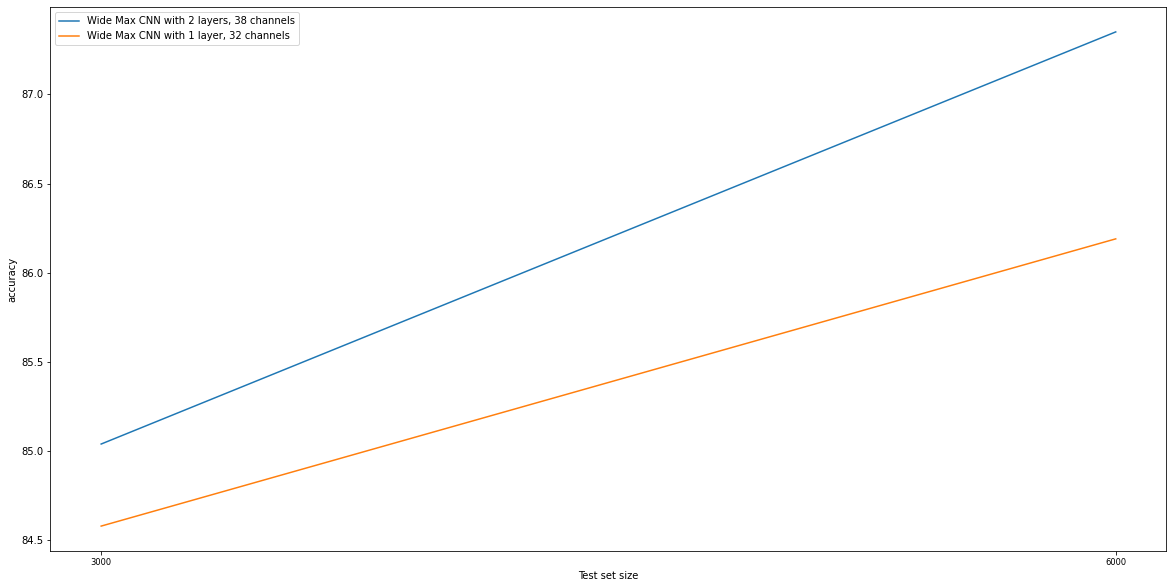

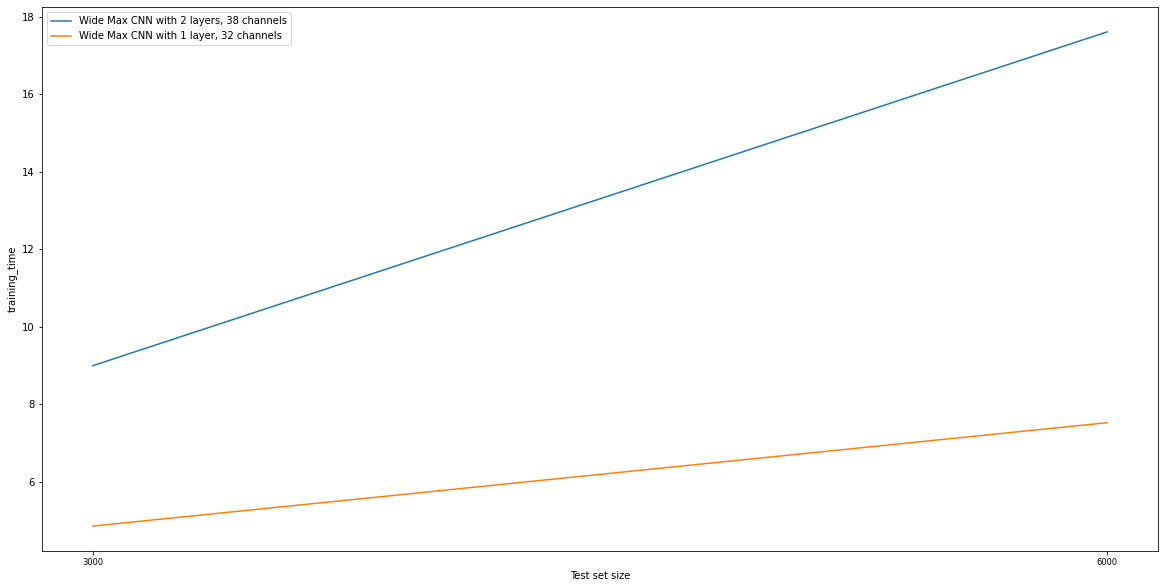

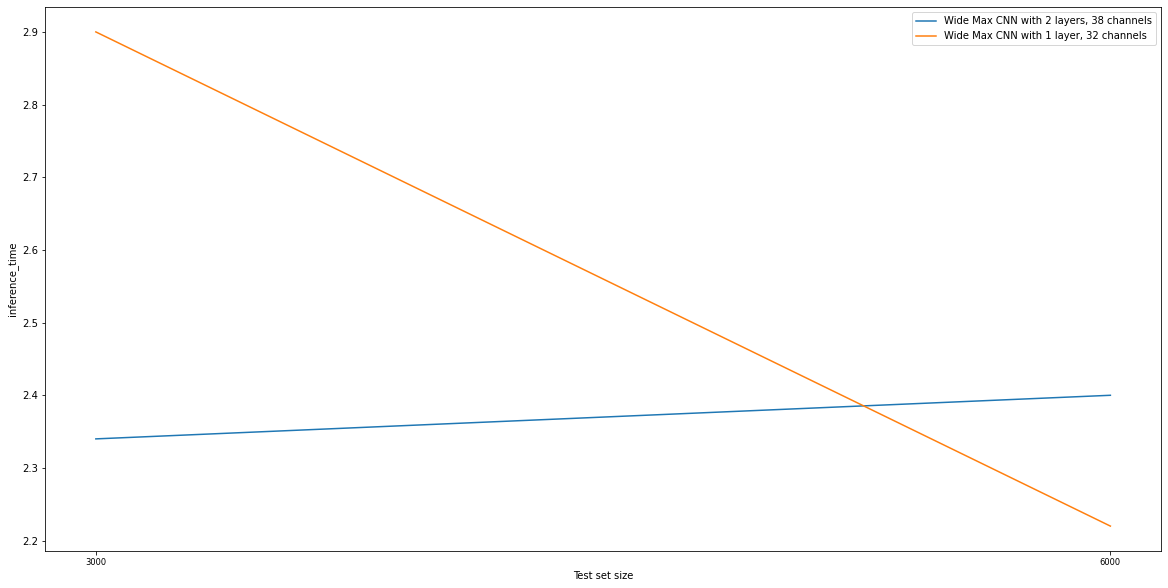

In [41]:
for i in ['accuracy', 'training_time', 'inference_time']:
    my_model = dic[i]
    cnnmax_a = cnnmax[i][:2]

    fig=plt.figure(figsize=(20,10)) #Creates a new figure
    
    ax1=fig.add_subplot(111) 
    ax1.plot(my_model,label='Wide Max CNN with 2 layers, 38 channels') # with 3 layers it would be worse.
    ax1.plot(cnnmax_a,label='Wide Max CNN with 1 layer, 32 channels') 


    plt.setp(ax1.get_xticklabels(), visible=True) #not ax2
    plt.xticks(range(2), list_of_sample_size[:2], size='small')
    plt.legend()
    plt.xlabel('Test set size')
    plt.ylabel(i)